# Two examples to illustrate the usage of root cause discovery method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import itertools
np.set_printoptions(suppress=True, precision=10)

from funcs.simulation_setting_funcs import *
from funcs.root_cause_discovery_funcs import *

## 1. Example 1 in the paper

In [2]:
def root_cause_discovery_allperm(X_obs, X_int):
    p = X_obs.shape[1]
    assert p == len(X_int), "Number of variables mismatch"
    
    z = zscore(X_obs, X_int)
    root_cause_score = np.zeros(p)
    permutations = list(itertools.permutations(range(p)))
    # try all permutations to calculate 'Xtilde'
    for perm in permutations:
        Xtilde = root_cause_discovery(X_obs, X_int, perm)
        sorted_X = sorted(Xtilde)
        OneNonZero_quantification = (sorted_X[-1] - sorted_X[-2]) / sorted_X[-2]
        max_index = np.argmax(Xtilde)
        if root_cause_score[max_index] < OneNonZero_quantification:
            root_cause_score[max_index] = OneNonZero_quantification

    # assign final root cause score for variables that never had maximal Xtilde_i
    idx2 = np.where(root_cause_score == 0)[0]
    if len(idx2) != 0:
        idx1 = np.where(root_cause_score != 0)[0]
        max_RC_score_idx2 = np.min(root_cause_score[idx1])/2
        root_cause_score[idx2] = z[idx2] / (np.max(z[idx2]) / max_RC_score_idx2)
    return root_cause_score

def example1_plt(ax, data, RC, ylabel, xlabel, title, color_dict, labels, marker_styles, font_size=12, log_y=False):
    for i in range(data.shape[1]):
        RC_idx = np.full(data.shape[0], 0)
        if i == RC:
            RC_idx = np.full(data.shape[0], 1)
        ax.scatter(
            np.arange(RC*data.shape[0]+1, RC*data.shape[0]+11),  # X-axis from 1 to data.shape[0]
            data[:, i],
            color=[color_dict[idx] for idx in RC_idx],
            marker=marker_styles[i],  # Use different marker styles for each column
            alpha=0.7,  # Add some transparency to avoid overlap
            s=50,  # Marker size
            edgecolor='k'  # Add border to markers
        )

    # Set log scale for y-axis if log_y is True
    if log_y:
        ax.set_yscale('log')

    # Set X-axis ticks from 1 to 10
    ax.set_xticks(np.arange(RC*data.shape[0]+1, RC*data.shape[0]+11))  # X-axis values 1, 2, ..., 10
    ax.set_xticklabels(np.arange(RC*data.shape[0]+1, RC*data.shape[0]+11), fontsize=font_size)  # Set labels for the x-axis

    # Add labels and title
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability

In [3]:
# Simulations for Example 1 in the paper

np.random.seed(0)

m = 30
int_r=10

p = 3
n = 100
b1 = 1
b2 = 1
b3 = 1

sigma_C = 1
sigma_j = 1
sigma_k = 1
alpha = -1
beta = 2
gamma = 1

# check the success condition:  > 0 holds
# check = sigma_k**2 + gamma**2 * sigma_C**2  + 2*alpha*beta*gamma*sigma_C**2
# print(check<0)

# observational sample
C = np.full(n, b1) + np.random.normal(0, 1, n)
Xj = np.full(n, b2) + beta*C + np.random.normal(0, 1, n)
Xk = np.full(n, b3) + alpha*Xj + gamma*C + np.random.normal(0, 1, n)
obs_data = np.column_stack((C,Xj,Xk))

# random intervention for each sample
delta_C = np.zeros(m)
delta_j = np.zeros(m)
delta_k = np.zeros(m)
# Inter_target = np.random.choice([1,2,3], m)
Inter_target = np.concatenate((np.full(m//3, 1), np.full(m//3, 2), np.full(m//3, 3)))

delta_C[Inter_target==1] = np.full(np.sum(Inter_target==1), int_r)
delta_j[Inter_target==2] = np.full(np.sum(Inter_target==2), int_r)
delta_k[Inter_target==3] = np.full(np.sum(Inter_target==3), int_r)
# interventional sample
C_I = np.full(m, b1) + np.random.normal(0, 1, m) + delta_C
Xj_I = np.full(m, b2) + beta*C_I + np.random.normal(0, 1, m) + delta_j 
Xk_I = np.full(m, b3) + alpha*Xj_I + gamma*C_I + np.random.normal(0,1, m) + delta_k
intv_data = np.column_stack((C_I,Xj_I,Xk_I))

Zscore_mat = zscore(obs_data, intv_data)

RCscore_mat = np.zeros(intv_data.shape)
for sample_idx in range(intv_data.shape[0]):
    intv_one_sample = intv_data[sample_idx,:]
    RCscore_mat[sample_idx,:] = root_cause_discovery_allperm(obs_data, intv_one_sample)


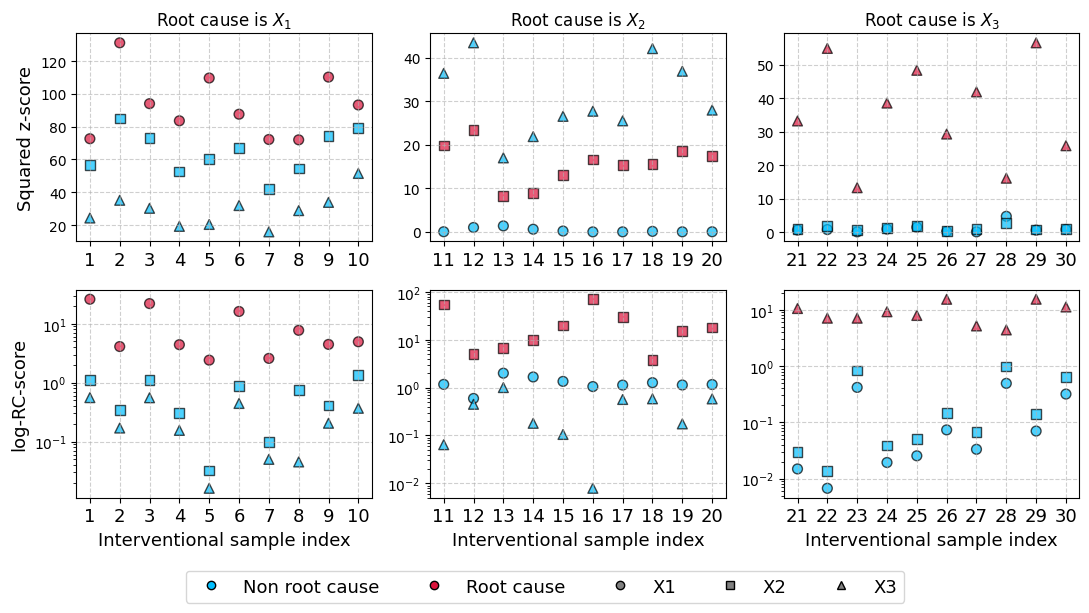

In [4]:
# Draw Plots
Zscore_int1 = Zscore_mat[0:10,]
Zscore_int2 = Zscore_mat[10:20,]
Zscore_int3 = Zscore_mat[20:30,]
RCscore_int1 = RCscore_mat[0:10,]
RCscore_int2 = RCscore_mat[10:20,]
RCscore_int3 = RCscore_mat[20:30,]


# Define colors and labels
color_dict = {0: 'deepskyblue', 1: 'crimson'}
labels = ['X1', 'X2', 'X3']
marker_styles = ['o', 's', '^']  # Different markers: circle, square, and triangle

# Create subplots for a 3x2 layout with a more compact design
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(11, 6))

font_size=13

# Plot Zscore_mat and RCscore_mat
example1_plt(ax1, Zscore_int1, RC=0, ylabel='Squared z-score', xlabel='', title='Root cause is $X_1$', 
             color_dict=color_dict, labels=labels, marker_styles=marker_styles, font_size=font_size, log_y=False)
example1_plt(ax2, Zscore_int2, RC=1, ylabel='', xlabel='', title='Root cause is $X_2$', 
             color_dict=color_dict, labels=labels, marker_styles=marker_styles, font_size=font_size, log_y=False)
example1_plt(ax3, Zscore_int3, RC=2, ylabel='', xlabel='', title='Root cause is $X_3$', 
             color_dict=color_dict, labels=labels, marker_styles=marker_styles, font_size=font_size, log_y=False)

example1_plt(ax4, RCscore_int1, RC=0, ylabel='log-RC-score', xlabel='Interventional sample index', title='', 
             color_dict=color_dict, labels=labels, marker_styles=marker_styles, font_size=font_size, log_y=True)
example1_plt(ax5, RCscore_int2, RC=1, ylabel='', xlabel='Interventional sample index', title='', 
             color_dict=color_dict, labels=labels, marker_styles=marker_styles, font_size=font_size, log_y=True)
example1_plt(ax6, RCscore_int3, RC=2, ylabel='', xlabel='Interventional sample index', title='', 
             color_dict=color_dict, labels=labels, marker_styles=marker_styles, font_size=font_size, log_y=True)

# Create a common legend for the figure at the bottom
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[0], markersize=6, label='Non root cause', markeredgecolor='k'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[1], markersize=6, label='Root cause', markeredgecolor='k'),
    plt.Line2D([0], [0], marker=marker_styles[0], color='w', markerfacecolor='gray', markersize=6, label='X1', markeredgecolor='k'),
    plt.Line2D([0], [0], marker=marker_styles[1], color='w', markerfacecolor='gray', markersize=6, label='X2', markeredgecolor='k'),
    plt.Line2D([0], [0], marker=marker_styles[2], color='w', markerfacecolor='gray', markersize=6, label='X3', markeredgecolor='k')
]

# Add the common legend at the bottom of the figure
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=5, prop={'size': 13})

# Adjust the layout for a more compact appearance
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the final plot
plt.show()

## Example 2. random DAG

In [5]:
n = 100
s_B = 0.5
dag_type = "random"

p = 10
nshuffles = 10

B_value_min = -1
B_value_max = 1
err_min = 1
err_max = 5
var_X_min = 10
var_X_max = 50

delta_r = 20

In [6]:
np.random.seed(321)
B, sigma2_error, b = generate_setting(dag_type, s_B, B_value_min, B_value_max, err_min, err_max, var_X_min, var_X_max, 
                                      p=p,tol=5, step_size=0.1, max_count=500) 
I = np.identity(p)
X_obs = np.zeros((n, p))
for i in range(n):
    error = np.random.multivariate_normal(np.repeat(0, p), sigma2_error, 1)
    X_obs[i, :] = linalg.solve(I - B, (b + error).T).reshape(p)

RC = 6 # X7 is intervened
delta = np.repeat(0, p)
delta[RC] = delta_r
error = np.random.multivariate_normal(np.repeat(0, p), sigma2_error, 1)
X_int = linalg.solve(I - B, (b + error + delta).T).reshape(p)

Zscores = zscore(X_obs, X_int)
CholScores = root_cause_discovery_main(X_obs, X_int, nshuffles=nshuffles, verbose=False)

In [8]:
# Results
print("Raw Value:")
print(np.round(abs(X_int),2))
print(f"Rank of RC: {sum(abs(X_int) > abs(X_int)[RC])+1}", "\n")

print("Z-score:")
print(np.round(abs(Zscores),2))
print(f"Rank of RC: {sum(abs(Zscores) > abs(Zscores)[RC])+1}", "\n")

print("Cholesky-score:")
print(np.round(abs(CholScores),2))
print(f"Rank of RC: {sum(abs(CholScores) > abs(CholScores)[RC])+1}", "\n")

Raw Value:
[30.19 74.78 27.01 42.2  43.64  0.8  22.77 86.33 43.01  8.05]
Rank of RC: 8 

Z-score:
[ 30.   182.88  43.83  75.23  76.98   0.27  13.62 171.62 145.16   1.27]
Rank of RC: 8 

Cholesky-score:
[0.19 3.53 0.06 1.08 1.11 2.64 7.54 3.47 2.04 0.03]
Rank of RC: 1 

